<a href="https://colab.research.google.com/github/CarrieIsPop/MAR-IA/blob/main/AI%20ENTRENAMIENTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1:

In [12]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil

2:

In [17]:
validation_path = '/content/drive/My Drive/Validation'
train_path = '/content/drive/My Drive/Train'

3:

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=25,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1.0/255)

4:

In [30]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 2000 // batch_size # Ahora es 31
validation_steps = 2000 // batch_size # Ahora es 31
epochs=8

5:

In [31]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Train',
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    seed=1337,
                                                    target_size=(64, 64))

validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Validation',
                                                          batch_size=64,
                                                          class_mode='binary',
                                                          seed=1337,
                                                          target_size=(64, 64))

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


6:

In [32]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

7:

In [34]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

8:

In [35]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 384)      │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 500)      │     1,728,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 500)      │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 500)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     1,026,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 30,591,621 (116.70 MB)

 Trainable params: 30,587,805 (116.68 MB)

 Non-trainable params: 3,816 (14.91 KB)

9:

In [36]:
model.compile(optimizer=Adam(adam),
              loss='binary_crossentropy'
              ,metrics=['accuracy'])

10:

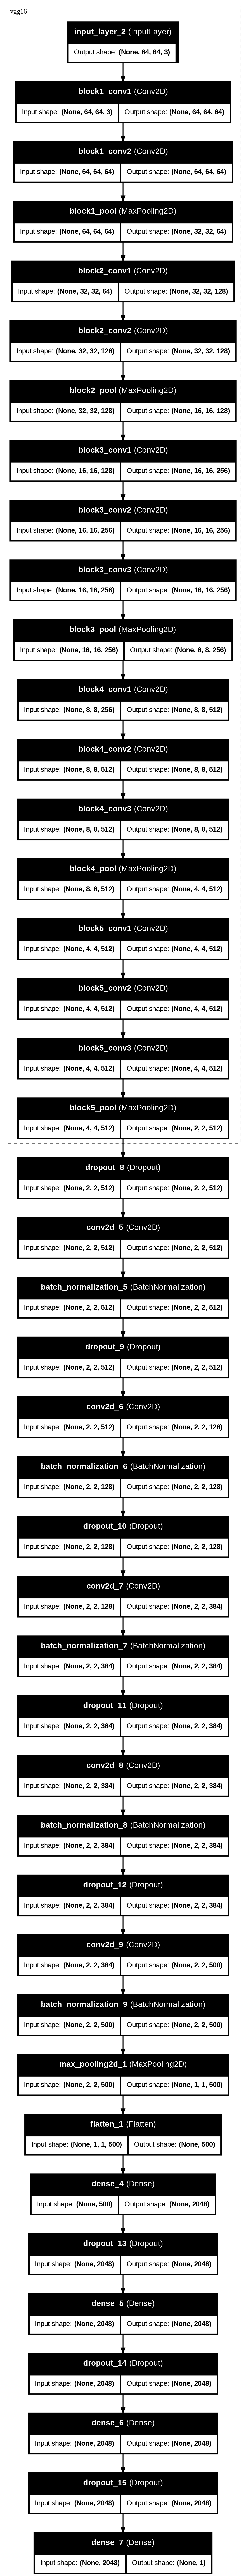

In [37]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

11:

In [39]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = patience,
                        verbose = verbose ,
                        factor = factor,
                        min_lr = min_lr)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=verbose, patience=patience)

12:

In [ ]:
%time
hist = model.fit(x=train_generator,
                 validation_data=validation_generator,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps,
                 epochs=epochs,
                 callbacks=[lrd, mcp, es])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5142 - loss: 2.2366 

31/31 ━━━━━━━━━━━━━━━━━━━━ 588s 19s/step - accuracy: 0.5142 - loss: 2.2083 - val_accuracy: 0.4990 - val_loss: 1.1037 - learning_rate: 0.0010
Epoch 2/8
 1/31 ━━━━━━━━━━━━━━━━━━━━ 8:02 16s/step - accuracy: 0.5156 - loss: 0.7263

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.5156 - loss: 0.7263 - val_accuracy: 0.4980 - val_loss: 1.0436 - learning_rate: 0.0010
Epoch 3/8
 3/31 ━━━━━━━━━━━━━━━━━━━━ 7:32 16s/step - accuracy: 0.4470 - loss: 0.7618

13:

In [ ]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

14:

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "../input/testmodel/test1.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

15:

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "../input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)